In [3]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
np.random.seed(1234)

## 3D spin model

I implemented gaussian kernel-approximation using SGD to 3-spin model, introduced in the 2018 paper by Vanden Eijnden and Grant Rostkoff entitled 'Trainability and Accuracy of Neural Networks: An Interacting Particle System Approach'. Then I compared losses in both the deterministic and the stochastic cases incurred in training by different algorithms, which I plotted. 

In [4]:
def spin_func(x,a):
    """
    Calculate the spin function for a given set of vectors and coefficients.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    n = x.shape[0]
    d = x.shape[1]
    y = x[:,np.newaxis, :]* x[:,:, np.newaxis]
    y = y[:,:,:,np.newaxis]* x[:,np.newaxis, np.newaxis, :]
    z = y*a[np.newaxis,:,:,:]
    return 1/d*z.sum(axis = (1,2,3)).reshape((1,n))

def grad_spin_func(x,a):
    """
    Calculate the gradient of the spin function with respect to the input vectors.

    Parameters:
    x (np.ndarray): An array representing a set of vectors with shape (n, d).
    a (np.ndarray): An array of coefficients with shape (d, d, d).

    Returns:
    np.ndarray: An array containing the gradient of the spin function with shape (n, d).
    """

    n = x.shape[0]
    d = x.shape[1]
    df = 1/d*np.array([((a[p,:,:]+a[:,p,:]+a[:,:,p])[np.newaxis, :,:]\
                *(x[:,np.newaxis,:]*x[:,:, np.newaxis])).sum(axis = (1,2)) for p in range(d)]).reshape(n,d)
    return df

def spin_func_slice(X,Y,a,d = 5):
    """
    Calculate the spin function for a given pair of angles and coefficients.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    a (np.ndarray): An array of coefficients with shape (d, d, d).
    d (int): The dimensionality of the vectors (default is 5).

    Returns:
    np.ndarray: An array containing the computed spin values with shape (1, n).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X), 0, 0]).reshape(1,d)
    return spin_func(x, a)

vspin_func_slice = np.vectorize(spin_func_slice)
vspin_func_slice.excluded.add(2)

In [5]:
#Initialise params
d = 5
a = np.random.normal(np.zeros((d,d,d)), np.ones((d,d,d)))

([], [])

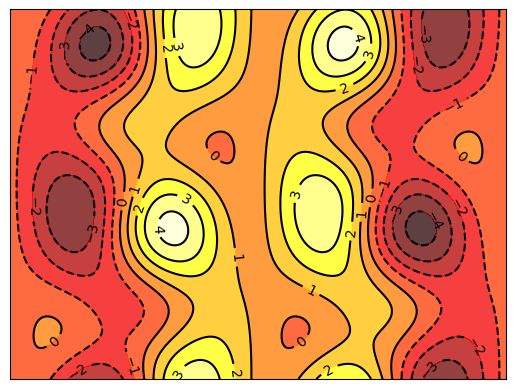

In [6]:
#contour plot of spin function
n = 256
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vspin_func_slice(X, Y, a), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vspin_func_slice(X,Y, a), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])

In [2]:
def neural_net_symm(x, c, z):
    """
    Compute the output of a symmetric neural network for given input and parameters.

    Parameters:
    x (np.ndarray): An input vector of shape (1, d).
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    z = np.array(z)
    n = z.shape[0]
    d = z.shape[1]
    c = c.reshape(1,n)
    return 1/n*(np.exp(-x@z.T)@c.T).reshape(1,x.shape[0])

def neural_net_slice(X, Y, c, z, d = 5):
    """
    Compute the output of a symmetric neural network for given angles and parameters.

    Parameters:
    X (float): The first angle.
    Y (float): The second angle.
    c (np.ndarray): Coefficients of the neural network with shape (1, n).
    z (np.ndarray): Weight matrix with shape (n, d).
    d (int): The dimensionality of the input vectors (default is 5).

    Returns:
    np.ndarray: The output of the symmetric neural network with shape (1, 1).
    """
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X), 0, 0]).reshape(1,d)
    return neural_net_symm(x, c, z)
vneural_net_slice = np.vectorize(neural_net_slice)
vneural_net_slice.excluded.add(2)
vneural_net_slice.excluded.add(3)

In [8]:
def sample_uniform_sphere(r, d, n):
    """
    Generate random points uniformly distributed on the surface of a d-dimensional sphere with radius 'r'.

    Parameters:
    r (float): The radius of the sphere.
    d (int): The dimensionality of the sphere.
    n (int): The number of points to generate.

    Returns:
    np.ndarray: An array of shape (n, d) containing 'n' random points sampled uniformly on the sphere's surface.
    """
    s = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    norm = np.sqrt(np.diag(s@s.T)).reshape(n,1)
    result = r*s/norm
    return result

In [81]:
#Training
def train(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        loss1 = -1/n*c@spin_func(z, a).T+0.5*1/n**2*c@exp@c.T
        
        #neural_net_symm(z,c,z)
        
        #c_next = c + (spin_func(z, a)-1/n*c@exp)*Dt 
        #z_next = z + (c.T*grad+1/n*(c.T*exp)@(c.T*z))*Dt

        #c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        #z_next = z + ((c.T*exp_x.T)@(spin_func(x, a).T*x)-1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        
        c_next = c + (spin_func(z, a)@exp-1/n*c@exp.T@exp)*Dt/n
        z_next = z + ((c.T*exp.T)@(spin_func(z, a).T*z)-1/n*(c.T*exp.T@((exp@c.T)*z)))*Dt/n
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)
        z = z_next
        c = c_next
        
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

([], [])

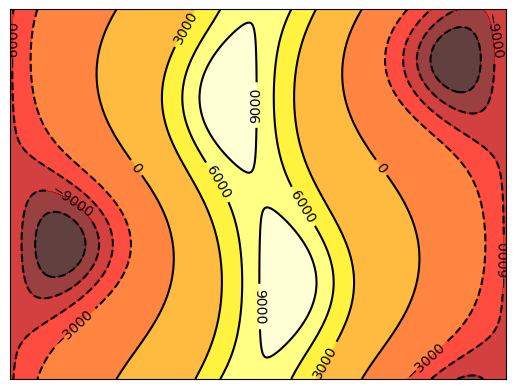

In [205]:
#contour plot of neural net reconstruction
n = 256
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vneural_net_slice(X, Y, c,z), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vneural_net_slice(X,Y, c,z), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])

In [206]:
#Training
def train_SGD(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Stochastic Gradient Descent (SGD).

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        
        c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        z_next = z + ((c.T*exp_x.T)@(spin_func(x, a).T*x)-1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)
        z = z_next
        c = c_next
        
        losses[step] = loss
        print('loss: {}'.format(loss))
                
    return c,z, losses

In [208]:
#Training with Nesterov accelerated gd
def nesterov_train_stochastic(d = 5, n = 16, Dt = 1e3, r = 3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z
    
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        exp_x = np.exp(-x@z_change.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)    
        
        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        z_next = z_change + ((c_change.T*exp_x.T)@(spin_func(x, a).T*x)\
                             -1/n*(c_change.T*exp_x.T@((exp_x@c_change.T)*x)))*Dt/P
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)

        
        c_change = c_next + 0.9*(c_next-c1)
        z_change = z_next + 0.9*(z_next-z1)
        z = z_next
        c = c_next
        
        
        losses[step] = loss
        print('loss: {}'.format(loss))
        z = z_next
        c = c_next
        
        
    return c,z, losses

In [177]:
#Training with Nesterov accelerated gd
def nesterov_train_deterministic(d = 5, n = 16, Dt = 1e3, r = 3, steps = int(2*1e5)):
    """
    Train a neural network with symmetric architecture on a given spin system using Nesterov's accelerated gradient descent.

    Parameters:
    d (int): The dimensionality of the spin system (default is 5).
    n (int): The number of neural network units (default is 16).
    Dt (float): Time step for training (default is 1e3).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    steps (int): The number of training steps (default is 200,000).

    Returns:
    tuple: A tuple containing the trained neural network coefficients 'c', the weight matrix 'z',
           and an array of loss values during training.
    """
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    c_change = c
    z_change = z
    
    losses = np.zeros(steps)
    #update step
    for step in trange(1,steps+1):
        grad = grad_spin_func(z_change,a)
        exp = np.exp(-z_change@z_change.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)

        c1 = c
        z1 = z
        
        c_next = c_change + (spin_func(z_change, a)@exp-1/n*c@exp.T@exp)*Dt/n
        z_next = z_change + ((c_change.T*exp.T)@(spin_func(z_change, a).T*z_change)\
                      -1/n*(c_change.T*exp.T@((exp@c_change.T)*z_change)))*Dt/n
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)

        c_change = c_next + 0.9*(c_next-c1)
        z_change = z_next + 0.9*(z_next-z1)
        z = z_next
        c = c_next

        losses[step-1] = loss
        print('loss: {}'.format(loss))
            
    return c,z, losses

In [3]:
c,z, losses = train(n = 16, steps = 30000, Dt = 1e-8)

In [4]:
c,z, Nesterov_losses = nesterov_train_deterministic(n = 16, steps = 30000, Dt = 1e-8)

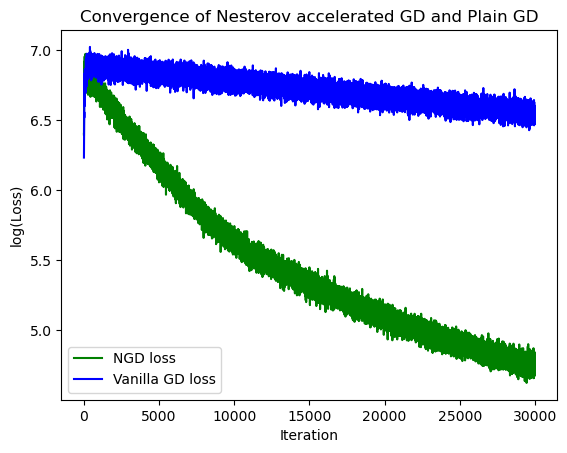

In [221]:
plt.plot(np.log10(Nesterov_losses), label = 'NGD loss', c = 'g')
plt.plot(np.log10(losses), label = 'Vanilla GD loss', c = 'b' )
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.title('Convergence of Nesterov accelerated GD and Plain GD')
plt.legend()

In [5]:
c,z, Nesterov_losses_sgd = nesterov_train_stochastic(n = 16, steps = 30000, Dt = 1e-8)

In [6]:
c,z, losses_sgd = train_SGD(n = 16, steps = 30000, Dt = 1e-8)

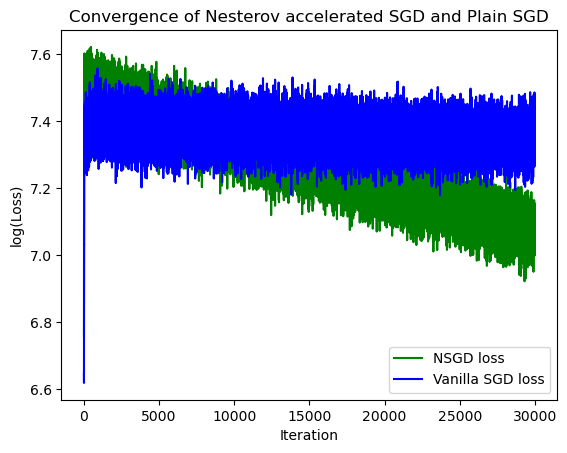

In [215]:
plt.plot(np.log10(Nesterov_losses_sgd), label = 'NSGD loss', c = 'g')
plt.plot(np.log10(losses_sgd), label = 'Vanilla SGD loss', c = 'b' )
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.title('Convergence of Nesterov accelerated SGD and Plain SGD')
plt.legend()

## General Observations

- In the deterministic gradient flow (with random initialization), the Nesterov accelerated loss (green) decreases towards a minimum much faster than regular gradient descent (blue), as expected.
- In the stochastic gradient flow (with random initialization), the Nesterov accelerated loss (green) decreases  towards a minimum faster than regular gradient descent (blue), though the losses stay closer together
